In [1]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from Bio.PDB import MMCIFParser, FastMMCIFParser
from Bio.PDB.MMCIF2Dict import MMCIF2Dict
from Bio.PDB.DSSP import DSSP
from Bio.PDB import PDBList
from Bio.SeqUtils import IUPACData

from loop.pdb_files import get_PDBfiles, parse_mmcif
from loop.dssp import generate_pdp_chain_pairs
from utils.common import load_tab, save_tab, dump_dicts2jsons, lower_pdbid, read_json2dict, dump_dict2json
from utils.protein import protein_letters_3to1

from utils.loops import print_loop_count

from domain_linker.cc_contact import contact, getCoords
from domain_linker.extract_linkers import get_2domain_start_end
from domain_linker.hbond import check_2Hbond
from params import *


for adding N- or C- terminus information. we don't need this.

# Functions

In [2]:
def bin_count(df_independent, bins: list):
    loop_length = list(df_independent['length'])
    
    cls = [np.round(np.random.rand(),1), np.round(np.random.rand(),1),np.round(np.random.rand(),1), 0.8]
    print(cls)
    plt.figure(figsize=(12, 6))
    counts, edges, bars = plt.hist(loop_length, bins=bins, color=cls)
    
    return counts, loop_length, edges

# generate intraDomainLoops table -- skippable

In [4]:
dict_terminus = read_json2dict(path_terminus)

In [5]:
'''
df_domain_loops_dist_smoothSS_second = load_tab(path_loops_domain_dist_hbond_contact_smoothSS_second)

t_contact = 4
t_hbond = 3

df_independent_2step, df_dependent_2step, df_contact_t_2step = clasify_interDomainLinker(df_domain_loops_dist_smoothSS_second, t_contact, t_hbond)
'''

'\ndf_domain_loops_dist_smoothSS_second = load_tab(path_loops_domain_dist_hbond_contact_smoothSS_second)\n\nt_contact = 4\nt_hbond = 3\n\ndf_independent_2step, df_dependent_2step, df_contact_t_2step = clasify_interDomainLinker(df_domain_loops_dist_smoothSS_second, t_contact, t_hbond)\n'

In [6]:
# loops_intra_domain_2step

In [5]:
df_terminus = pd.DataFrame()

for pdb_chainid_unp, loops in dict_terminus.items():
    df_loops = pd.json_normalize(loops)
    df_loops['pdbid'] = pdb_chainid_unp.split('_')[0].upper()
    df_loops['chain'] = pdb_chainid_unp.split('_')[1].upper()
    df_terminus = pd.concat([df_terminus, df_loops], axis=0, ignore_index=True)

In [6]:
print(df_terminus.shape[0])
df_terminus.columns


2994


Index(['start', 'end', 'seq_id', 'start_unp', 'end_unp', 'seq_id_unp', 'seq',
       'seq_unp', 'dssp_key_str', 'missing', 'miss_length', 'miss_percentage',
       'unp_acc', 'length', 'terminu', 'pdbid', 'chain'],
      dtype='object')

In [7]:
df_terminus[df_terminus['pdbid']=='2BNM']

,start,end,seq_id,start_unp,end_unp,seq_id_unp,seq,seq_unp,dssp_key_str,missing,miss_length,miss_percentage,unp_acc,length,terminu,pdbid,chain
1403,1,5,"[1, 2, 3, 4, 5]",1,5,"[1, 2, 3, 4, 5]","[M, S, N, T, K]","[M, S, N, T, K]","[A_1_ , A_2_ , A_3_ , A_4_ , A_5_ ]","[1, 1, 1, 1, 0]",4,0.8,Q56185,5,N,2BNM,A


In [8]:
df_terminus['seq'] = [' '.join(seq) for seq in df_terminus['seq']]
df_terminus['seq_unp'] = [' '.join(seq) for seq in df_terminus['seq_unp']]

## Update terminu info
- Add uniprot length info
- to check if the terminu is:
  C/N/intra-domain loops

**Get Uniprot sequence info**

In [9]:
df_pdbUniMap = load_tab(path_idxMap_pdb_chain_unp)
df_len_uniprot = df_pdbUniMap.loc[:, ['acc', 'len_seq_unp']]
df_len_uniprot = df_len_uniprot.drop_duplicates()
df_len_uniprot[:2]

,acc,len_seq_unp
0,P0AF28,216
1,P00969,359


In [10]:
df_len_uniprot.shape

(2631, 2)

**Get Uniprot & PDB chain sequence mapping, residue level: 1vs1**

In [11]:
# get the list of all pdb_chain_unp
df_terminus['pidChainUnp'] = [f"{r['pdbid'].lower()}_{r['chain'].lower()}_{r['unp_acc']}" for i, r in df_terminus.iterrows()]

for i, row in df_terminus.iterrows():
    pidChainUnp = row['pidChainUnp']
    # get chain information
    df_chain = pd.read_json(os.path.join(path_dssp_full_uniprot_chainid, f'{pidChainUnp}.json'))
    
    # get sequence start and end index (normal index in python, sequence index start from 0)
    unp_num = list(df_chain['unp_num'])
    start_idx = unp_num.index(row['start_unp'])
    end_idx = unp_num.index(row['end_unp'])
    df_terminus.loc[i, 'id'] = f'{pidChainUnp}_{start_idx}_{end_idx}'

In [12]:
df_terminus[:2]

,start,end,seq_id,start_unp,end_unp,seq_id_unp,seq,seq_unp,dssp_key_str,missing,miss_length,miss_percentage,unp_acc,length,terminu,pdbid,chain,pidChainUnp,id
0,2,6,"[2, 3, 4, 5, 6]",2,6,"[2, 3, 4, 5, 6]",S N Q E P,S N Q E P,"[A_2_ , A_3_ , A_4_ , A_5_ , A_6_ ]","[1, 1, 1, 0, 0]",3,0.600000,P0AF28,5,N,1A04,A,1a04_a_P0AF28,1a04_a_P0AF28_0_4
1,1,7,"[1, 2, 3, 4, 5, 6, 7]",33,39,"[33, 34, 35, 36, 37, 38, 39]",A D T T G R A,A D T T G R A,"[A_1_ , A_2_ , A_3_ , A_4_ , A_5_ , A_6_ , A_7_ ]","[1, 1, 1, 0, 0, 0, 0]",3,0.428571,P24055,7,N,1A21,A,1a21_a_P24055,1a21_a_P24055_0_6


**Merge**

In [14]:
df_terminus = df_terminus.merge(df_len_uniprot, left_on='unp_acc', right_on='acc', how='left')

In [15]:
df_terminus = df_terminus.drop(columns=['acc'])

In [16]:
df_terminus.loc[:, 'terminu'] = 'Intra'
df_terminus[:2]

,start,end,seq_id,start_unp,end_unp,seq_id_unp,seq,seq_unp,dssp_key_str,missing,miss_length,miss_percentage,unp_acc,length,terminu,pdbid,chain,pidChainUnp,id,len_seq_unp
0,2,6,"[2, 3, 4, 5, 6]",2,6,"[2, 3, 4, 5, 6]",S N Q E P,S N Q E P,"[A_2_ , A_3_ , A_4_ , A_5_ , A_6_ ]","[1, 1, 1, 0, 0]",3,0.600000,P0AF28,5,Intra,1A04,A,1a04_a_P0AF28,1a04_a_P0AF28_0_4,216
1,1,7,"[1, 2, 3, 4, 5, 6, 7]",33,39,"[33, 34, 35, 36, 37, 38, 39]",A D T T G R A,A D T T G R A,"[A_1_ , A_2_ , A_3_ , A_4_ , A_5_ , A_6_ , A_7_ ]","[1, 1, 1, 0, 0, 0, 0]",3,0.428571,P24055,7,Intra,1A21,A,1a21_a_P24055,1a21_a_P24055_0_6,292


In [17]:
df_terminus.shape

(3189, 20)

**update terminus**

In [18]:
df_terminus.loc[df_terminus['start_unp']<=3, 'terminu'] = 'N'
df_terminus.loc[[r['end_unp']>=(r['len_seq_unp']-3) for i, r in df_terminus.iterrows()], 'terminu'] = 'C'

In [19]:
# df_terminus.loc[[r['end_unp']>(r['len_seq_unp']-5) for i, r in df_terminus.iterrows()]]

In [20]:
print(f"C-terminu: {df_terminus.loc[df_terminus['terminu'] == 'C'].shape[0]}")
print(f"N-terminu: {df_terminus.loc[df_terminus['terminu'] == 'N'].shape[0]}")
print(f"Intra-sequence loops: {df_terminus.loc[df_terminus['terminu'] == 'Intra'].shape[0]}")

C-terminu: 875
N-terminu: 734
Intra-sequence loops: 1580


In [21]:
df_terminus.shape

(3189, 20)

## save result

In [22]:
path_terminus_tab = os.path.join(path_loops, 'final/terminus.tsv')
save_tab(df_terminus, path_terminus_tab)

# Plots

In [23]:
df_terminus = load_tab(path_terminus_tab)

In [24]:
df_terminus.sort_values(by='length', ascending=False)

,start,end,seq_id,start_unp,end_unp,seq_id_unp,seq,seq_unp,dssp_key_str,missing,miss_length,miss_percentage,unp_acc,length,terminu,pdbid,chain,pidChainUnp,id,len_seq_unp
2962,1741,2263,"[1741, 1742, 1743, 1744, 1745, 1746, 1747, 174...",1741,2263,"[1741, 1742, 1743, 1744, 1745, 1746, 1747, 174...",L K Q I L S G G H K A I M Q H N A T S E Q N I ...,L K Q I L S G G H K A I M Q H N A T S E Q N I ...,"['A_1741_ ', 'A_1742_ ', 'A_1743_ ', 'A_1744_ ...","[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",518,0.990440,A5HC98,523,C,5AMR,A,5amr_a_A5HC98,5amr_a_A5HC98_1740_2262,2263
2467,532,956,"[532, 533, 534, 535, 536, 537, 538, 539, 540, ...",532,956,"[532, 533, 534, 535, 536, 537, 538, 539, 540, ...",S L L I E R P S Q L T F A S S H N P D T H P T ...,S L L I E R P S Q L T F A S S H N P D T H P T ...,"['A_532_ ', 'A_533_ ', 'A_534_ ', 'A_535_ ', '...","[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",419,0.985882,P32504,425,C,4ACO,A,4aco_a_P32504,4aco_a_P32504_531_955,956
2578,1,221,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1,221,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",M S S V E E L T Q L F S Q V G F E D K K V K E ...,M S S V E E L T Q L F S Q V G F E D K K V K E ...,"['A_1_ ', 'A_2_ ', 'A_3_ ', 'A_4_ ', 'A_5_ ', ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",214,0.968326,P13188,221,N,4H3S,A,4h3s_a_P13188,4h3s_a_P13188_0_220,809
2781,62,261,"[62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 7...",62,261,"[62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 7...",G E M R R T P I R F A D I P Q D F I H A L L S ...,G E M R R T P I R F A D I P Q D F I H A L L S ...,"['A_62_ ', 'A_63_ ', 'A_64_ ', 'A_65_ ', 'A_66...","[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",191,0.955000,Q07806,200,Intra,4OON,A,4oon_a_Q07806,4oon_a_Q07806_26_225,822
2971,1,179,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1,179,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",M L N A W H L P V P P F V K Q S K D Q L L I T ...,M L N A W H L P V P P F V K Q S K D Q L L I T ...,"['A_1_ ', 'A_2_ ', 'A_3_ ', 'A_4_ ', 'A_5_ ', ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",130,0.726257,P21517,179,N,5BN7,A,5bn7_a_P21517,5bn7_a_P21517_0_178,604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1729,419,420,"[419, 420]",419,420,"[419, 420]",R G,R G,"['A_419_ ', 'A_420_ ']","[0, 0]",0,0.000000,P61497,2,C,2J07,A,2j07_a_P61497,2j07_a_P61497_418_419,420
1793,287,288,"[287, 288]",288,289,"[288, 289]",L K,L K,"['A_287_ ', 'A_288_ ']","[0, 1]",1,0.500000,P0AGE9,2,C,2NU7,A,2nu7_a_P0AGE9,2nu7_a_P0AGE9_286_287,289
1841,496,497,"[496, 497]",495,496,"[495, 496]",K A,K A,"['A_496_ ', 'A_497_ ']","[0, 0]",0,0.000000,A4GWM6,2,Intra,2OMT,A,2omt_a_A4GWM6,2omt_a_A4GWM6_459_460,800
92,214,215,"[214, 215]",332,333,"[332, 333]",F W,F W,"['A_214_ ', 'A_215_ ']","[0, 1]",1,0.500000,P40189,2,Intra,1BQU,A,1bqu_a_P40189,1bqu_a_P40189_213_214,918


In [25]:
multi_domain = load_tab(path_tab_scop_FA_continuous_uni_multi_parse_domian)
multi_domain[multi_domain['FA-PDBID']=='5I08']

,FA-DOMID,FA-PDBID,FA-PDBREG,FA-UNIID,FA-UNIREG,FA,FA-UNIREG-START,FA-UNIREG-END,FA-PDBREG-START,FA-PDBREG-END,FA-CHAINID,seq_id,length,experiment_type,resolution


## All

In [26]:
length =  df_terminus['length']
max(length), min(length)

(523, 2)

[0.4, 0.2, 0.6, 0.8]


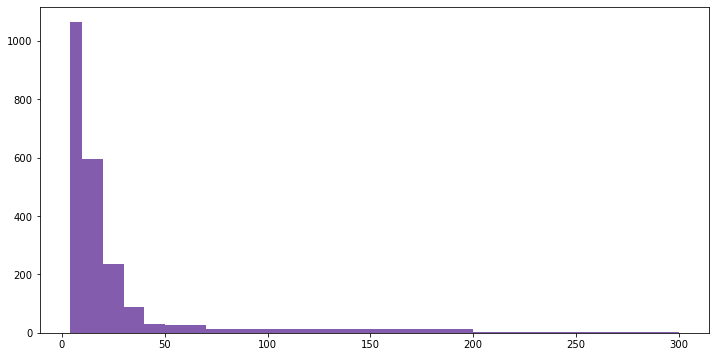

In [26]:
bins = [4, 10, 20, 30, 40, 50, 70, 100, 200, 350]
counts_intra, length_intra, _ = bin_count(df_terminus, bins)

Text(0, 0.5, 'Length of terminus')

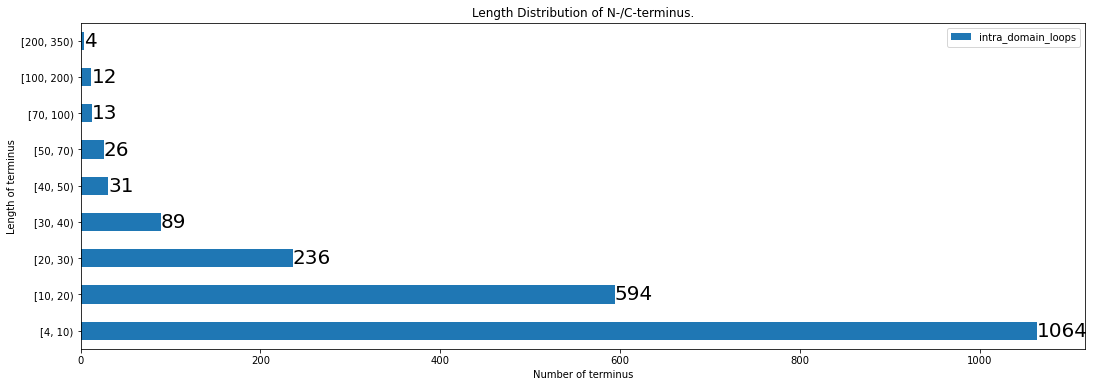

In [28]:
x = [u'[4, 10)', u'[10, 20)', u'[20, 30)', u'[30, 40)', u'[40, 50)', u'[50, 70)', u'[70, 100)', u'[100, 200)', u'[200, 350)']
y = counts_intra

# index = ['snail', 'pig', 'elephant','rabbit', 'giraffe', 'coyote', 'horse']
df = pd.DataFrame({'intra_domain_loops': y})
df = df.set_axis(x)
ax = df.plot.barh(figsize=(18,6))
# ax.axhline(0, color='grey', linewidth=0.8)
ax.bar_label(ax.containers[0], fontsize=20)

ax.set_title('Length Distribution of N-/C-terminus.')
ax.set_xlabel('Number of terminus')
ax.set_ylabel('Length of terminus')